<a href="https://colab.research.google.com/github/RasinduHansaka/Assignment_DL/blob/main/CNN_2D_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Required Dependencies

In [4]:
!pip install keras-tuner --quiet

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import os
import librosa
import librosa.display
import glob
import skimage

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.preprocessing import StandardScaler
import joblib

import keras_tuner as kt
import tensorflow as tf

## Dataset Preparation

###  Load and Prepare Data

In [6]:
df=pd.read_csv('./augmented_normal_data.csv')

X = df.drop(columns=['label']).values
y = df['label'].values

In [7]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (43660, 128)
Shape of y: (43660,)


### One-Hot Encoding

In [8]:
y=np.array(pd.get_dummies(y,dtype=int))

### SMOTE for Balanced Sampling

In [9]:
# Assuming X and y are your features and target labels
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert one-hot encoded labels back to class labels
y_resampled_labels = np.argmax(y_resampled, axis=1)

# Check the distribution of data after resampling
counter = Counter(y_resampled_labels)
print("Class distribution after resampling:\n", counter)

Class distribution after resampling:
 Counter({np.int64(3): 5000, np.int64(2): 5000, np.int64(1): 5000, np.int64(0): 5000, np.int64(9): 5000, np.int64(6): 5000, np.int64(8): 5000, np.int64(5): 5000, np.int64(7): 5000, np.int64(4): 5000})


### Data Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=1, test_size=0.2)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (40000, 128)
Shape of X_test: (10000, 128)
Shape of y_train: (40000, 10)
Shape of y_test: (10000, 10)


### Scaling

In [11]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, 'standard_scaler_cnn_2d.pkl')

['standard_scaler_cnn_2d.pkl']

In [12]:
X_train = X_train.reshape(len(X_train), 16, 8, 1)
X_test = X_test.reshape(len(X_test), 16, 8, 1)

In [13]:
input_dim = (16, 8, 1)

## Hyperparameter Tuning

### Function build_model

In [14]:

from tensorflow.keras import Input


class CNNHyperModel(kt.HyperModel):

    def __init__(self, input_shape, output_units):
        self.input_shape = input_shape
        self.output_units = output_units

    def build(self, hp):
        model = Sequential()

        model.add(Input(shape=self.input_shape))

        # First Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('filters_1', min_value=32, max_value=256, step=32),
            kernel_size=(hp.Choice('kernel_height_1', values=[3, 5]), hp.Choice('kernel_width_1', values=[3, 5])),
            activation=hp.Choice('activation_1', values=['relu', 'tanh']),
            padding='same',

            #
        ))
        model.add(MaxPool2D(pool_size=(2, 2)))

        # Second Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('filters_2', min_value=32, max_value=256, step=32),
           kernel_size=(hp.Choice('kernel_height_1', values=[3, 5]), hp.Choice('kernel_width_1', values=[3, 5])),
            activation=hp.Choice('activation_2', values=['relu', 'tanh']),
            padding='same'
        ))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('dropout_1', min_value=0, max_value=0.5, step=0.1)))

        # Flatten and Dense layers
        model.add(Flatten())
        model.add(Dense(hp.Int('dense_units', min_value=128, max_value=1024, step=128),
                        activation=hp.Choice('dense_activation', values=['relu', 'tanh'])))
        model.add(Dropout(hp.Float('dropout_2', min_value=0, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(self.output_units, activation='softmax'))

        # Compile the model
        model.compile(
            optimizer=tf.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

In [15]:
input_shape = X_train.shape[1:]
output_units = y_train.shape[1]

# Initialize CNNHyperModel
cnn_hypermodel = CNNHyperModel(input_shape=input_shape, output_units=output_units)

# Set up early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Set up Keras Tuner with RandomSearch strategy
possible_epochs = [50, 100]

for epoch_count in possible_epochs:
    print(f"Training with {epoch_count} epochs")

    tuner = kt.RandomSearch(
        cnn_hypermodel,
        objective='val_accuracy',
        max_trials=10,  # Number of different hyperparameter combinations to try
        executions_per_trial=1,  # Number of executions for each trial
        directory='cnn_tuner',
        project_name=f'cnn_epoch_{epoch_count}'
    )

    # Start the hyperparameter search
    tuner.search(
        X_train, y_train,
        epochs=epoch_count,
        validation_split=0.2,
        callbacks=[early_stopping]
    )

    # Retrieve the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best hyperparameters for {epoch_count} epochs: {best_hps.values}")

Trial 10 Complete [00h 01m 12s]
val_accuracy: 0.7662500143051147

Best val_accuracy So Far: 0.9267500042915344
Total elapsed time: 00h 24m 16s
Best hyperparameters for 100 epochs: {'filters_1': 128, 'kernel_height_1': 5, 'kernel_width_1': 3, 'activation_1': 'tanh', 'filters_2': 224, 'activation_2': 'relu', 'dropout_1': 0.1, 'dense_units': 128, 'dense_activation': 'tanh', 'dropout_2': 0.4, 'learning_rate': 0.000215710835819955}


### Best hyperparameters

In [16]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
for hp_name, hp_value in best_hyperparameters.values.items():
    print(f"{hp_name}: {hp_value}")

Best Hyperparameters:
filters_1: 128
kernel_height_1: 5
kernel_width_1: 3
activation_1: tanh
filters_2: 224
activation_2: relu
dropout_1: 0.1
dense_units: 128
dense_activation: tanh
dropout_2: 0.4
learning_rate: 0.000215710835819955


In [17]:
import pandas as pd

# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Convert hyperparameters to a pandas DataFrame
hyperparameters_df = pd.DataFrame(list(best_hyperparameters.values.items()), columns=["Hyperparameter", "Value"])

In [18]:
hyperparameters_df

,Hyperparameter,Value
0,filters_1,128
1,kernel_height_1,5
2,kernel_width_1,3
3,activation_1,tanh
4,filters_2,224
5,activation_2,relu
6,dropout_1,0.1
7,dense_units,128
8,dense_activation,tanh
9,dropout_2,0.4


### Best hyperparameters for diffrenet epochs

In [19]:
import pandas as pd

# Initialize a list to hold dictionaries of hyperparameters for each epoch count
hyperparameters_list = []

for epoch_count in possible_epochs:
    # Retrieve the stored Keras Tuner object for each epoch
    tuner = kt.RandomSearch(
        cnn_hypermodel,
        objective='val_accuracy',
        max_trials=10,  # Number of different hyperparameter combinations to try
        executions_per_trial=1,  # Number of executions for each trial
        directory='cnn_tuner',
        project_name=f'cnn_epoch_{epoch_count}'
    )

    # Get best hyperparameters
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0].values

    # Add the epoch count to the dictionary of hyperparameters
    hyperparameters = {"epoch_count": epoch_count, **best_hyperparameters}

    # Append the dictionary to the list
    hyperparameters_list.append(hyperparameters)

# Create a DataFrame from the list of hyperparameter dictionaries
best_params_df = pd.DataFrame(hyperparameters_list)

# Specify columns to keep
columns_to_keep = [
    'epoch_count', 'filters_1', 'kernel_height_1', 'kernel_width_1',
    'activation_1', 'filters_2', 'activation_2', 'dropout_1',
    'dense_units', 'dense_activation', 'dropout_2'
]

# Filter DataFrame to display only the desired columns
best_params_df_filtered = best_params_df[columns_to_keep]


Reloading Tuner from cnn_tuner/cnn_epoch_50/tuner0.json
Reloading Tuner from cnn_tuner/cnn_epoch_100/tuner0.json


In [20]:
best_params_df_filtered

,epoch_count,filters_1,kernel_height_1,kernel_width_1,activation_1,filters_2,activation_2,dropout_1,dense_units,dense_activation,dropout_2
0,50,128,5,3,relu,96,tanh,0.3,1024,relu,0.1
1,100,128,5,3,tanh,224,relu,0.1,128,tanh,0.4


### Best Model Test

In [30]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
best_model.save('best_cnn_2d_model.keras')

In [23]:
test_accuracy=best_model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.932200014591217


In [24]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
for hp_name, hp_value in best_hyperparameters.values.items():
    print(f"{hp_name}: {hp_value}")

Best Hyperparameters:
filters_1: 128
kernel_height_1: 5
kernel_width_1: 3
activation_1: tanh
filters_2: 224
activation_2: relu
dropout_1: 0.1
dense_units: 128
dense_activation: tanh
dropout_2: 0.4
learning_rate: 0.000215710835819955


## Train the Best Model again

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3708 - loss: 1.7935 - val_accuracy: 0.5546 - val_loss: 1.3187
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5494 - loss: 1.2909 - val_accuracy: 0.6211 - val_loss: 1.1256
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6257 - loss: 1.0937 - val_accuracy: 0.6606 - val_loss: 1.0029
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6666 - loss: 0.9856 - val_accuracy: 0.6859 - val_loss: 0.9236
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7015 - loss: 0.8978 - val_accuracy: 0.7284 - val_loss: 0.8561
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7295 - loss: 0.8036 - val_accuracy: 0.7531 - val_loss: 0.7807
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7468 - loss: 0.7509 - val_accuracy: 0.7546 - val_loss: 0.7198
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7627 - loss: 0

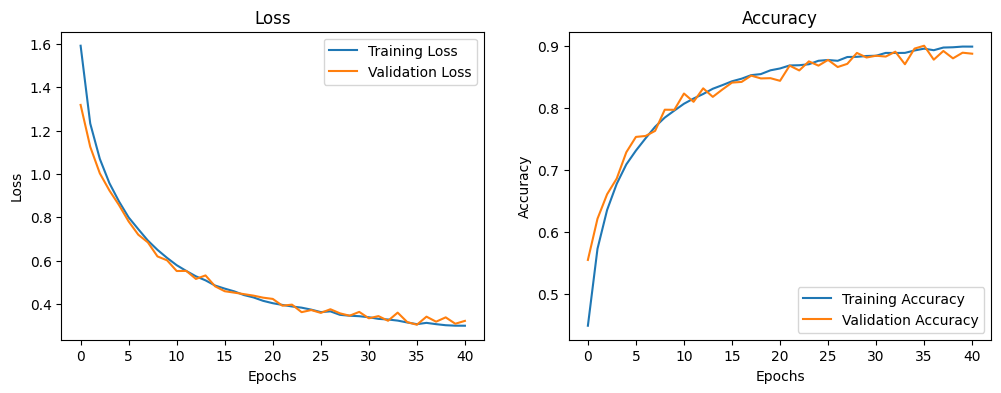

In [25]:
# Rebuild the best model using the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Initialize the hypermodel with input and output parameters
cnn_hypermodel = CNNHyperModel(input_shape=input_shape, output_units=output_units)

# Build the model using the best hyperparameters
model = cnn_hypermodel.build(best_hyperparameters)

# Train the model again, this time keeping track of the history for plotting
history = model.fit(
    X_train, y_train,
    epochs=100,  # You can set an appropriate number of epochs here
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plotting Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 4))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.906499981880188


In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 16, 8, 128)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 4, 224)      │       430,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 2, 224)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 2, 224)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,989,440 (7.59 MB)

 Trainable params: 663,146 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,326,294 (5.06 MB)

## Classfication Report

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
                  precision    recall  f1-score   support

 air_conditioner       0.95      0.88      0.91      1016
        car_horn       1.00      0.96      0.98      1010
children_playing       0.80      0.73      0.77       939
        dog_bark       0.96      0.82      0.88       987
        drilling       0.99      0.92      0.96      1000
   engine_idling       0.91      0.91      0.91       993
        gun_shot       0.99      0.94      0.96       986
      jackhammer       0.98      0.98      0.98      1072
           siren       0.80      0.97      0.87      1032
    street_music       0.75      0.93      0.83       965

        accuracy                           0.91     10000
       macro avg       0.91      0.90      0.91     10000
    weighted avg       0.91      0.91      0.91     10000



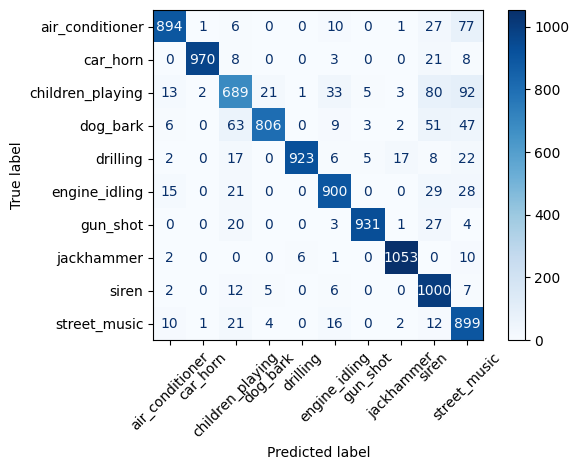

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Class names
class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
               'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

# Get prediction probabilities from the softmax layer
y_pred_prob = model.predict(X_test)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_test_classes = np.argmax(y_test, axis=1)   # y_test is one-hot in your notebook

# Print classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names, zero_division=0))

# Plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()


## Confution Matrix

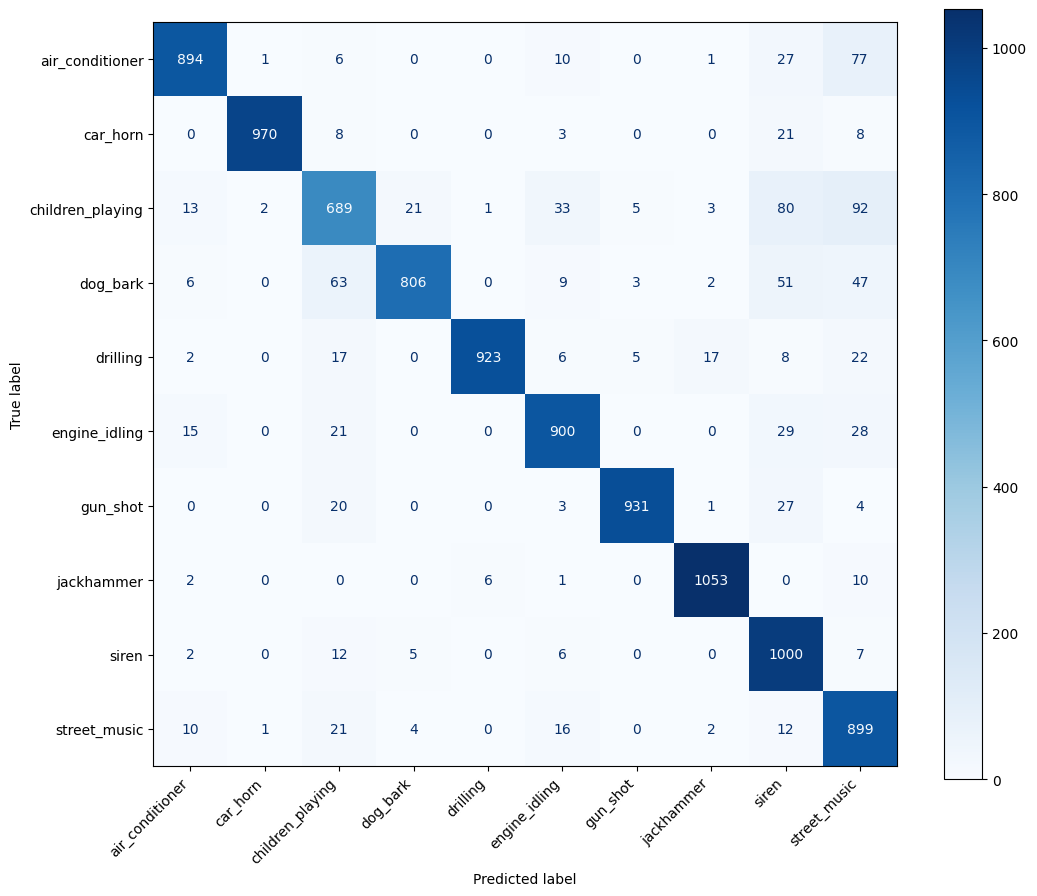

In [32]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))  # Specify figure size directly in subplots

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass the axis to the plot method

ax.set_xticklabels(disp.display_labels, rotation=45, ha='right')  # Rotate class names on x-axis for better readability

plt.show()